<a href="https://colab.research.google.com/github/Mizoroki-Heck/Forecasting-a-Time-Series-of-Real-Estate-Prices/blob/main/_v_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.interpolate import UnivariateSpline
from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta

### Считываем данные и обработка

In [ ]:
data = pd.read_excel('/content/sample_data/Средняя_цена_1_кв_м_общей_площади_квартир_на_рынке_жилья.xls', skiprows=3)
# pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,I квартал,II квартал,III квартал,IV квартал,I квартал.1,II квартал.1,III квартал.1,...,IV квартал.21,I квартал.22,II квартал.22,III квартал.22,IV квартал.22,I квартал.23,II квартал.23,III квартал.23,IV квартал.23,I квартал.24
0,Вторичный рынок жилья,Российская Федерация,Все типы квартир,5910.45,5955.02,6103.58,6590.17,7300.88,7723.86,8291.11,...,76686.26,89867.64,91637.43,92892.27,94362.82,90891.50,92363.00,94526.47,97418.39,108127.06
1,Вторичный рынок жилья,Российская Федерация,Квартиры среднего качества (типовые),5710.34,5791.35,5929.36,6421.56,6943.38,7391.32,7957.78,...,70513.74,83236.73,83985.15,85155.79,86770.32,85532.32,87084.49,88734.00,91593.07,98296.29
2,Вторичный рынок жилья,Российская Федерация,Низкого качества,4942.25,4930.57,5079.02,5482.66,6121.54,6357.71,6684.85,...,61353.55,71741.33,73576.96,72096.70,72265.28,72572.55,74282.35,76135.63,77719.26,84074.07
3,Вторичный рынок жилья,Российская Федерация,Улучшенного качества,6712.89,6704.89,6877.55,7422.19,8065.37,8480.71,9134.58,...,83011.86,97482.92,99908.63,101459.09,102928.68,100502.50,101951.86,105024.44,108246.66,117948.54
4,Вторичный рынок жилья,Российская Федерация,Элитные квартиры,11422.90,11393.16,11606.28,12009.49,13636.33,14192.89,14671.29,...,118912.23,146663.64,157717.52,161595.15,162842.36,133657.26,132641.54,135485.26,137342.62,212078.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,Первичный рынок жилья,Восточно-Сибирский район,Элитные квартиры,7048.55,7060.77,7307.24,9560.06,9829.22,11753.79,12758.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,Первичный рынок жилья,Дальневосточный район,Все типы квартир,7203.56,7392.97,7434.40,7987.61,10614.19,11180.25,11995.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989,Первичный рынок жилья,Дальневосточный район,Квартиры среднего качества (типовые),5653.88,5653.88,6000.00,6299.25,6591.40,6991.40,6991.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,Первичный рынок жилья,Дальневосточный район,Улучшенного качества,6913.49,7036.90,6954.79,7457.41,9789.78,10418.40,11766.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Поменяем названия кварталов на более понятные**

In [ ]:
quarters = ['Q1',	'Q2',	'Q3',	'Q4']
years = [i for i in range(2000, 2025)]
combined = []

for year in years:
  if year == 2024:
    combined.append(f"{year}-Q1")
  else:
    for quarter in quarters:
          combined.append(f"{year}-{quarter}")

In [ ]:
combined = ['Тип квартиры'] + combined
combined = ['Территория'] + combined
combined = ['Тип рынка жилья'] + combined
data.columns = combined

**Приведем таблицу к виду, где наша цена, будет одной колонкой**

In [ ]:
df_melted = data.melt(id_vars=['Тип рынка жилья', 'Территория', 'Тип квартиры'], var_name='Квартал',value_name='Цена')
df_melted

,Тип рынка жилья,Территория,Тип квартиры,Квартал,Цена
0,Вторичный рынок жилья,Российская Федерация,Все типы квартир,2000-Q1,5910.45
1,Вторичный рынок жилья,Российская Федерация,Квартиры среднего качества (типовые),2000-Q1,5710.34
2,Вторичный рынок жилья,Российская Федерация,Низкого качества,2000-Q1,4942.25
3,Вторичный рынок жилья,Российская Федерация,Улучшенного качества,2000-Q1,6712.89
4,Вторичный рынок жилья,Российская Федерация,Элитные квартиры,2000-Q1,11422.90
...,...,...,...,...,...
96219,Первичный рынок жилья,Восточно-Сибирский район,Элитные квартиры,2024-Q1,NaN
96220,Первичный рынок жилья,Дальневосточный район,Все типы квартир,2024-Q1,NaN
96221,Первичный рынок жилья,Дальневосточный район,Квартиры среднего качества (типовые),2024-Q1,NaN
96222,Первичный рынок жилья,Дальневосточный район,Улучшенного качества,2024-Q1,NaN


**У нас есть нулевые значения цены, больше всего нулей в Аcтраханской области, всего таких нулевых записей 27, заменим их на Nan. Потому что я сильно сомневаюсь, что когда то квартиры раздавали бесплатно :D**


In [ ]:
df_melted.describe().T

,count,mean,std,min,25%,50%,75%,max
Цена,68889.0,44039.899677,35290.056011,0.0,19270.19,39725.2,55123.63,644497.47


In [ ]:
df_null_value = df_melted.loc[(df_melted['Цена']==0)]
df_null_value.groupby(['Территория'])['Цена'].count()

,Цена
Территория,
Астраханская область,16
Мурманская область,1
Орловская область,2
Республика Дагестан,1
Республика Марий Эл,1
Республика Северная Осетия-Алания,2
Ставропольский край,4


In [ ]:
df_melted['Цена'] = df_melted['Цена'].replace(0, np.nan)

**В данных присутствует столбец южного федерального округа поделенный на три столбца по разным датам это создает дополнительные Nan.
Например начиная с 2010 года в столбце 'Южный федеральный округ (по 2009 год)' идут Nan до 2024 года и по такой логике все остальные столбцы.**

**- 'Южный федеральный округ (по 2009 год)'**   
**- 'Южный федеральный округ (с 2010 года)'**     
**- 'Южный федеральный округ (с 29.07.2016)'**
           
**Попробуем их объединить**

In [ ]:
# Сделаем дату индексом, тем самым приведем к виду временного ряда
df_melted['Квартал'] = pd.PeriodIndex(df_melted['Квартал'], freq='Q').to_timestamp(how='end')
df_melted = df_melted.set_index('Квартал')

df_melted.index = pd.to_datetime(df_melted.index)
df_melted.index = df_melted.index.normalize()
#Удалим лишние пробелы из колонки территория
df_melted['Территория'] = df_melted['Территория'].str.strip()

In [ ]:
df_melted

,Тип рынка жилья,Территория,Тип квартиры,Цена
Квартал,,,,
2000-03-31,Вторичный рынок жилья,Российская Федерация,Все типы квартир,5910.45
2000-03-31,Вторичный рынок жилья,Российская Федерация,Квартиры среднего качества (типовые),5710.34
2000-03-31,Вторичный рынок жилья,Российская Федерация,Низкого качества,4942.25
2000-03-31,Вторичный рынок жилья,Российская Федерация,Улучшенного качества,6712.89
2000-03-31,Вторичный рынок жилья,Российская Федерация,Элитные квартиры,11422.90
...,...,...,...,...
2024-03-31,Первичный рынок жилья,Восточно-Сибирский район,Элитные квартиры,NaN
2024-03-31,Первичный рынок жилья,Дальневосточный район,Все типы квартир,NaN
2024-03-31,Первичный рынок жилья,Дальневосточный район,Квартиры среднего качества (типовые),NaN


In [ ]:
df_melted = df_melted.sort_index()

**Наглядный пример, посмотрим на данные ЮФО по 2009 года и с 2010, с элитным жильем**

In [ ]:
df_melted.loc[(df_melted['Территория'] == 'Южный федеральный округ (по 2009 год)') & (df_melted['Тип квартиры'] == 'Элитные квартиры')]['2009-12-31':'2010-03-31']

,Тип рынка жилья,Территория,Тип квартиры,Цена
Квартал,,,,
2009-12-31,Вторичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,60454.91
2009-12-31,Первичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,49922.43
2010-03-31,Вторичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,NaN
2010-03-31,Первичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,NaN


In [ ]:
df_melted.loc[(df_melted['Территория'] == 'Южный федеральный округ (с 2010 года)') & (df_melted['Тип квартиры'] == 'Элитные квартиры')]['2009-12-31':'2010-03-31']

,Тип рынка жилья,Территория,Тип квартиры,Цена
Квартал,,,,
2009-12-31,Вторичный рынок жилья,Южный федеральный округ (с 2010 года),Элитные квартиры,NaN
2009-12-31,Первичный рынок жилья,Южный федеральный округ (с 2010 года),Элитные квартиры,NaN
2010-03-31,Вторичный рынок жилья,Южный федеральный округ (с 2010 года),Элитные квартиры,54775.90
2010-03-31,Первичный рынок жилья,Южный федеральный округ (с 2010 года),Элитные квартиры,43931.09


In [ ]:
df_melted.isna().sum()

,0
Тип рынка жилья,0
Территория,0
Тип квартиры,0
Цена,27362


**Cделаем функцию, где мы будем проходить по всем комбинациям типов квартир и рынка жилья и заменять NaN соответствующими значениями других столбцов и запишем это в столбец с 2009 годом, остальные удалим**

In [ ]:
def union_sfo(df):
  type_apartment = df['Тип квартиры'].unique()
  type_market = df['Тип рынка жилья'].unique()

  for i in type_apartment:
    for j in type_market:
      mask1 = (df['Территория'] == 'Южный федеральный округ (по 2009 год)') & (df['Тип квартиры'] == i) & (df['Тип рынка жилья'] == j)
      mask2 = (df['Территория'] == 'Южный федеральный округ (с 2010 года)') & (df['Тип квартиры'] == i) & (df['Тип рынка жилья'] == j)
      mask3 = (df['Территория'] == 'Южный федеральный округ (с 29.07.2016)') & (df['Тип квартиры'] == i) & (df['Тип рынка жилья'] == j)

      str1 = df[mask1]
      str2 = df[mask2]
      str3 = df[mask3]

      combined_df = str1.combine_first(str2.combine_first(str3))

      df.loc[mask1] = combined_df


In [ ]:
union_sfo(df_melted)
df_melted.isna().sum()

,0
Тип рынка жилья,0
Территория,0
Тип квартиры,0
Цена,26849


In [ ]:
df_melted.loc[(df_melted['Территория'] == 'Южный федеральный округ (по 2009 год)') & (df_melted['Тип квартиры'] == 'Элитные квартиры')]['2009-12-31':'2010-03-31']

,Тип рынка жилья,Территория,Тип квартиры,Цена
Квартал,,,,
2009-12-31,Вторичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,60454.91
2009-12-31,Первичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,49922.43
2010-03-31,Вторичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,54775.90
2010-03-31,Первичный рынок жилья,Южный федеральный округ (по 2009 год),Элитные квартиры,43931.09


In [ ]:
#Удаляем столбцы ЮФО 2010 и 2016 года.
df_melted = df_melted[~df_melted['Территория'].isin(['Южный федеральный округ (с 2010 года)', 'Южный федеральный округ (с 29.07.2016)'])]

In [ ]:
df_melted

,Тип рынка жилья,Территория,Тип квартиры,Цена
Квартал,,,,
2000-03-31,Вторичный рынок жилья,Российская Федерация,Все типы квартир,5910.45
2000-03-31,Вторичный рынок жилья,Российская Федерация,Квартиры среднего качества (типовые),5710.34
2000-03-31,Вторичный рынок жилья,Российская Федерация,Низкого качества,4942.25
2000-03-31,Вторичный рынок жилья,Российская Федерация,Улучшенного качества,6712.89
2000-03-31,Вторичный рынок жилья,Российская Федерация,Элитные квартиры,11422.90
...,...,...,...,...
2024-03-31,Первичный рынок жилья,Восточно-Сибирский район,Элитные квартиры,NaN
2024-03-31,Первичный рынок жилья,Дальневосточный район,Все типы квартир,NaN
2024-03-31,Первичный рынок жилья,Дальневосточный район,Квартиры среднего качества (типовые),NaN


**Посмотрим на пропуски по типам рынка жилья**

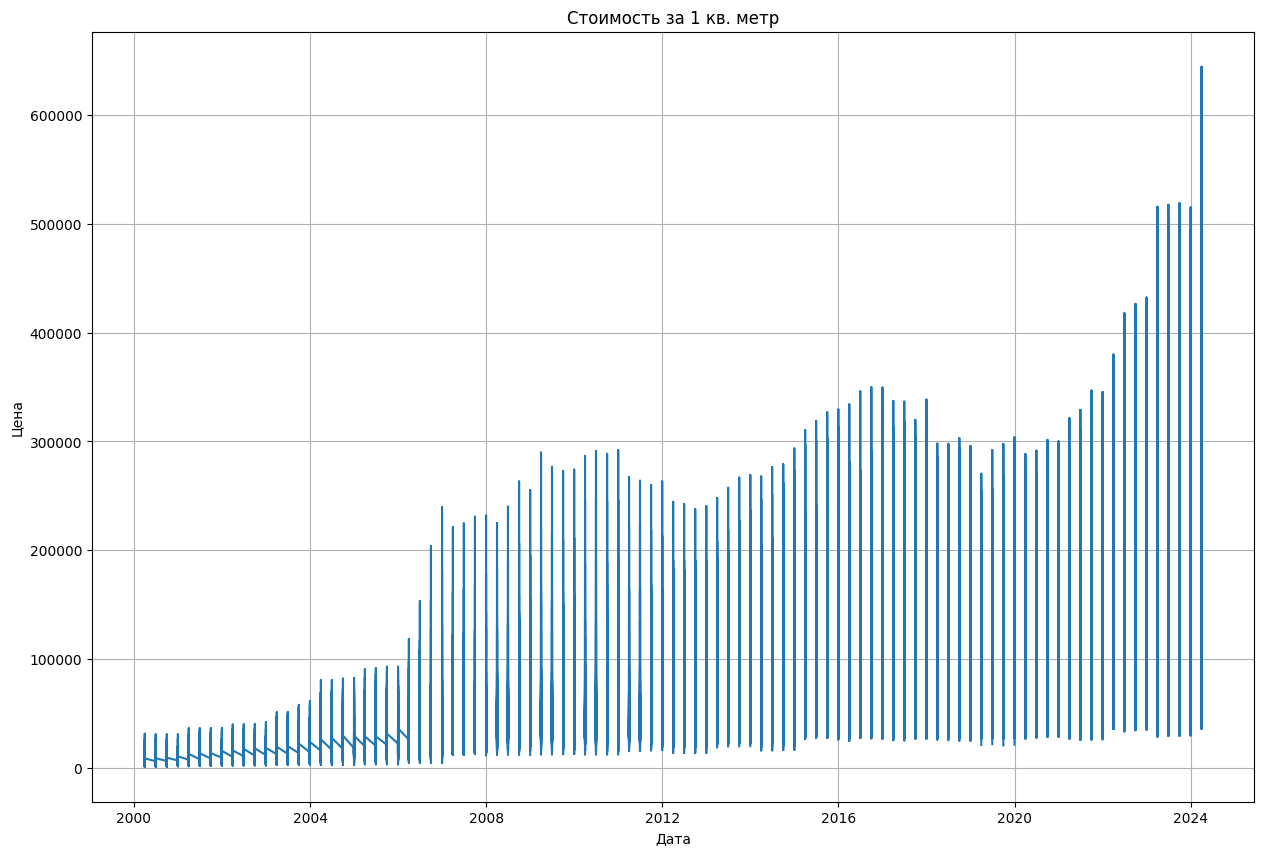

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_melted.index, df_melted['Цена'])

plt.title('Стоимость за 1 кв. метр')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)

plt.show()

In [ ]:
missing_values_by_region_and_market = df_melted.groupby(['Территория', 'Тип рынка жилья'])['Цена'].apply(lambda x: x.isnull().sum())
missing_values_by_region_and_market = missing_values_by_region_and_market.reset_index()
missing_values_by_region_and_market = missing_values_by_region_and_market.sort_values(by='Цена', ascending=False)

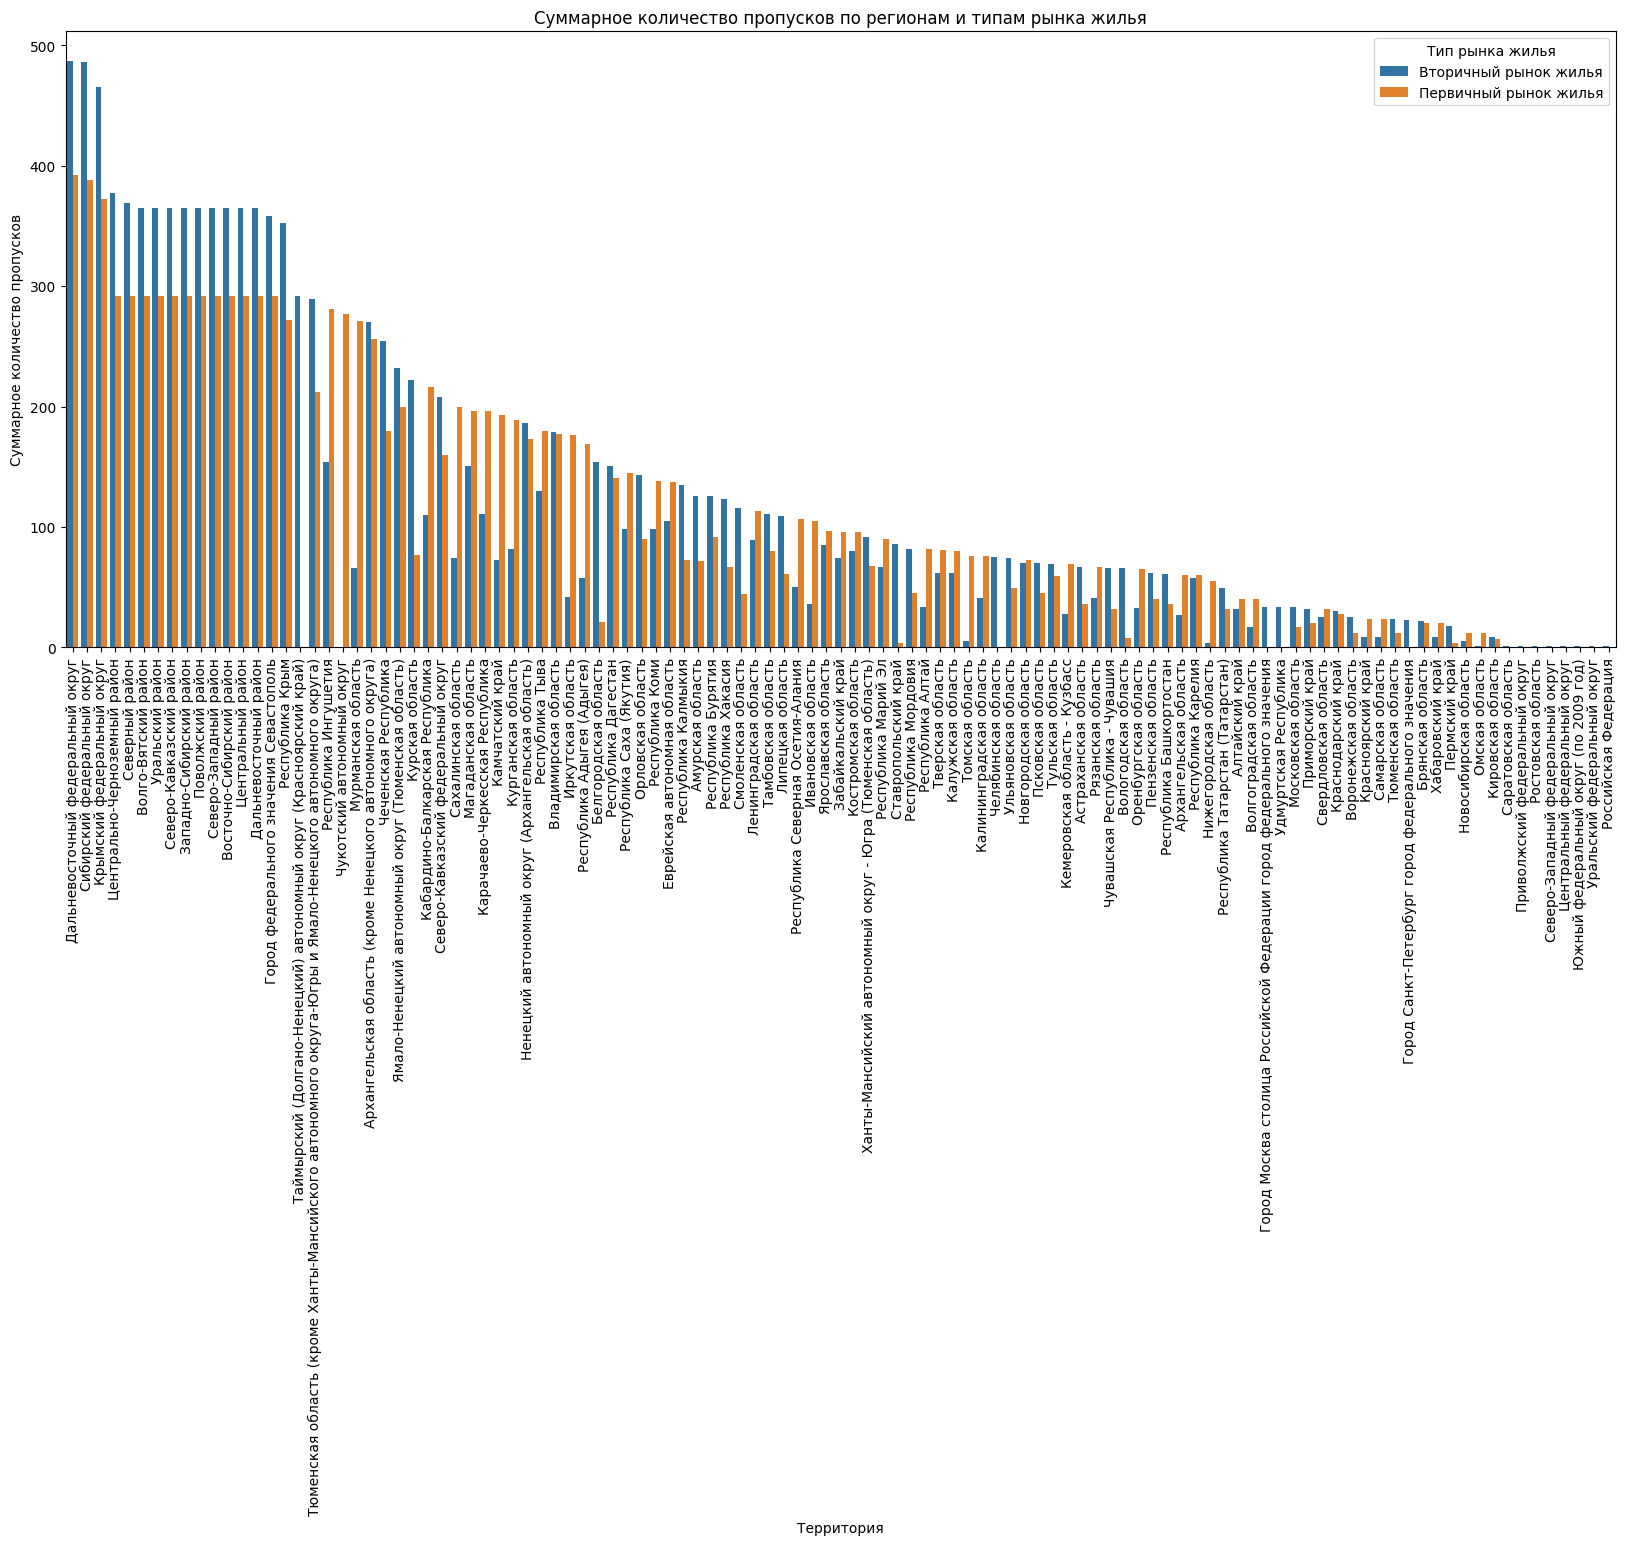

In [ ]:
missing_values_by_region_and_market = missing_values_by_region_and_market.reset_index()

# Визуализируем
plt.figure(figsize=(20, 8))
sns.barplot(data=missing_values_by_region_and_market, x='Территория', y='Цена', hue=('Тип рынка жилья'))
plt.xticks(rotation=90)
plt.title('Суммарное количество пропусков по регионам и типам рынка жилья')
plt.xlabel('Территория')
plt.ylabel('Суммарное количество пропусков')
plt.show()

В исходных данных можно заметить, что два региона имеют наибольшее количество пропусков. Это связано с тем, что эти два региона были дублированы по типам рынка, что привело к различному содержимому данных.         
      ***(Ниже покажу разницу в размерах колонок продублированных и не продублированных)***

Например, в данных по вторичному рынку жилья для "Дальневосточного федерального округа" существуют две колонки. В первой колонке данные представлены до 1 квартала 2019 года, но начиная с 2019 года наблюдаются пропуски. Во второй колонке, наоборот, пропуски имеются только за 1 квартал 2019 года, а данные доступны для последующих периодов.

**В таком случае, думаю будет уместно просто удалить пропущенные значения в этих колонках т.к после преобразований нашей таблицы, у нас имеется одна колонка региона, и имеются все данные из дублированных колонок в одном столбце**

А третий регион, Крымский федеральный округ, по понятным причинам, имеет очень мало данных.

**Видно, что размер Дальневосточного федерального округа, ровно в два раза больше, из за дублирования которое я имел ввиду.**

In [ ]:
print(len(df_melted.loc[(df_melted['Территория'] == 'Дальневосточный федеральный округ')]))
print(len(df_melted.loc[(df_melted['Территория'] == 'Иркутская область')]))

1746
873


In [ ]:
df_melted.isna().sum()

,0
Тип рынка жилья,0
Территория,0
Тип квартиры,0
Цена,25616


**Закодируем регионы, тип рынка, и тип квартиры**

In [ ]:
df_melted = pd.get_dummies(df_melted, prefix=['Тип рынка жилья', 'Территория', 'Тип квартиры'])
df_melted.replace({False: 0, True: 1}, inplace=True)

# Уберем лишние слова в названиях
df_melted.columns = df_melted.columns.str.replace('Территория_', '')
df_melted.columns = df_melted.columns.str.replace('Тип рынка жилья_', '')
df_melted.columns = df_melted.columns.str.replace('Тип квартиры_', '')
df_melted.columns = df_melted.columns.str.strip()

df_melted.rename(columns = {'Южный федеральный округ (по 2009 год)':'Южный федеральный округ'}, inplace = True )

<ipython-input-317-c51e6b87ef26>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_melted.replace({False: 0, True: 1}, inplace=True)


**Напишем функцию, для удаления Nan, и используем ее для удаления пропусков в наших дублированных регионах**

In [ ]:
def remove_nan_for_region(df, region_column):
  df_region = df[df[region_column]==1]
  df_region_cleaned = df_region.dropna(subset=['Цена'])
  df_melted_cleaned = df[df[region_column] == 0]
  df_final_cleaned = pd.concat([df_melted_cleaned, df_region_cleaned])

  return df_final_cleaned

In [ ]:
df_dalnevostok_cleaned = remove_nan_for_region(df_melted, 'Дальневосточный федеральный округ')
df_melted = remove_nan_for_region(df_dalnevostok_cleaned, 'Сибирский федеральный округ')

In [ ]:
df_melted = df_melted.sort_index()

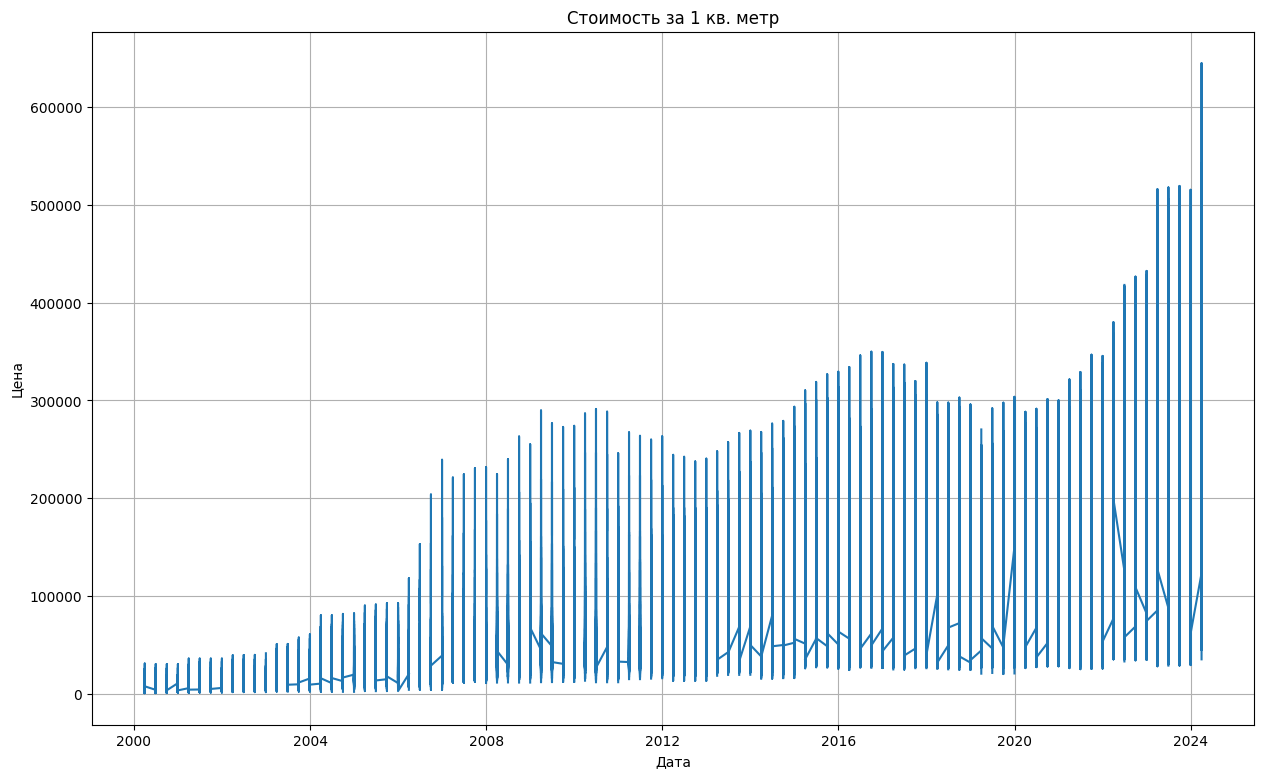

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(df_melted.index, df_melted['Цена'])

plt.title('Стоимость за 1 кв. метр')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)

plt.show()

In [ ]:
df_melted.isna().sum()

,0
Цена,23863
Вторичный рынок жилья,0
Первичный рынок жилья,0
Алтайский край,0
Амурская область,0
...,...
Все типы квартир,0
Квартиры среднего качества (типовые),0
Низкого качества,0
Улучшенного качества,0


**Посмотрим на долю пропусков, по рынкам и типам жилья**

In [ ]:
percentages_missing = {}

regions = df_melted.columns.tolist()
markets = ['Вторичный рынок жилья', 'Первичный рынок жилья']
type_apartments = ['Все типы квартир', 'Квартиры среднего качества (типовые)', 'Низкого качества', 'Улучшенного качества', 'Элитные квартиры']

for region in df_melted.columns:
  if region not in ['Цена'] + markets + type_apartments:
    for market in markets:
      for type_apartment in type_apartments:
        mask = (df_melted[region] == 1) & (df_melted[market] == 1) & (df_melted[type_apartment] == 1)
        filtered_df = df_melted.loc[mask]

        if len(filtered_df) > 0:# если таких строк нет, то не считать
          percentage_missing = (filtered_df['Цена'].isna().sum()) / len(filtered_df) *100
          percentages_missing[region+'--'+market+'--'+type_apartment] = percentage_missing


for region, percentage in percentages_missing.items():
  print(f"{region}: {percentage:.2f}% пропущенных значений'")


Алтайский край--Вторичный рынок жилья--Все типы квартир: 0.00% пропущенных значений'
Алтайский край--Вторичный рынок жилья--Квартиры среднего качества (типовые): 1.03% пропущенных значений'
Алтайский край--Вторичный рынок жилья--Низкого качества: 11.34% пропущенных значений'
Алтайский край--Вторичный рынок жилья--Улучшенного качества: 0.00% пропущенных значений'
Алтайский край--Вторичный рынок жилья--Элитные квартиры: 20.62% пропущенных значений'
Алтайский край--Первичный рынок жилья--Все типы квартир: 0.00% пропущенных значений'
Алтайский край--Первичный рынок жилья--Квартиры среднего качества (типовые): 41.24% пропущенных значений'
Алтайский край--Первичный рынок жилья--Улучшенного качества: 0.00% пропущенных значений'
Алтайский край--Первичный рынок жилья--Элитные квартиры: 0.00% пропущенных значений'
Амурская область--Вторичный рынок жилья--Все типы квартир: 0.00% пропущенных значений'
Амурская область--Вторичный рынок жилья--Квартиры среднего качества (типовые): 1.03% пропущенных 

**Думаю поступить с пропусками таким орбразом:**                
**1. Пропусков более 50% удаляем т.к какое то восстановление данных, может привести к сильным искажениям**               
**2.Остальные попробуем восстановить, сперва посмотрим на наш временной ряд, а конкретно стационарен он или нет, исходя из этого, подумаем, как заполнить пропуски**

In [ ]:
сombinations_to_remove = []

for region, percentage in percentages_missing.items():
    if percentage > 50:
        сombinations_to_remove.append(region)

for combination in сombinations_to_remove:
  region, market, type_apartment = combination.split('--')
  mask = (df_melted[region]==1) & (df_melted[market]==1) & (df_melted[type_apartment]==1)

  df_melted = df_melted.loc[~mask]


In [ ]:
df_melted = df_melted.sort_index()

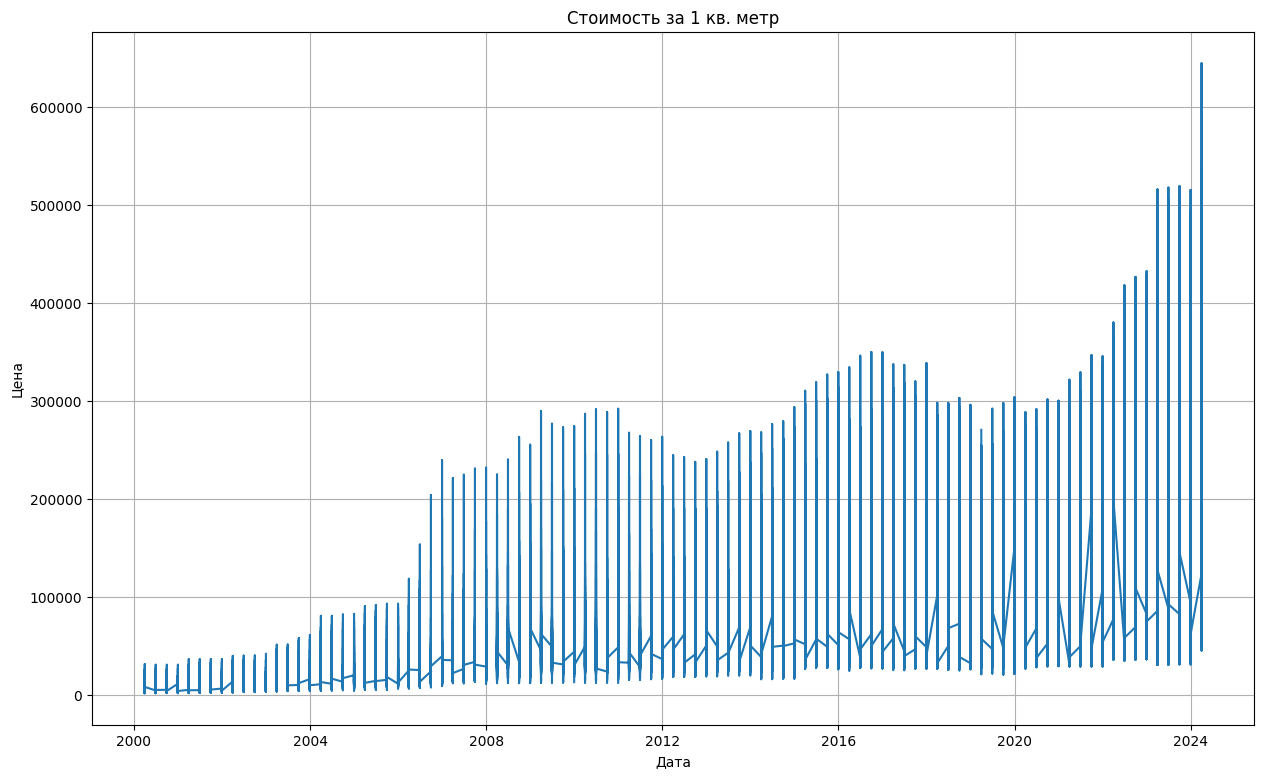

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(df_melted.index, df_melted['Цена'])

plt.title('Стоимость за 1 кв. метр')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)

plt.show()

**Судя по графику, ряд не стационарен, проведем тест Дики - Фулера**

In [ ]:
df_non_nan = df_melted.dropna()#удалим все пропуски для теста.

In [ ]:
result = adfuller(df_non_nan['Цена'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -6.800786019026203
p-значение: 2.2399167987587113e-09
Критические значения:
  1%: -3.430454770562165
  5%: -2.861586306639804
  10%: -2.566794647457513


**Мне показался странным результат теста, у нас получилось крайне низкое p-value, что означает, ряд стационарен, хотя судя по рисунку я сомневаюсь.**
**В тесте Дики-Фулера гипотезы формулируются так:**


---


**H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.**

**H A : Временной ряд является стационарным.**


---


**Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.**

**Проведем еще один тест KPSS(Квятковского-Филлипса-Шмидта-Шина)**

In [ ]:
series = df_non_nan['Цена']

result = kpss(series, regression='c')

print('KPSS статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:', result[3])

KPSS статистика: 36.736092154951365
p-значение: 0.01
Критические значения: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-329-34ff90ed4cdd>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


**Нулевая и альтернативная гипотезы для теста KPSS противоположны тесту Дики-Фулера.**


---


**H 0: процесс является стационарным по тренду.**                 
**H A: ряд имеет единичный корень (ряд не является стационарным).**


---


**Тут уже другое дело, у нас кпсс статистика, получилась сильно больше критических значений, p-value ниже 0.05, да еще и функция предупреждает, что фактическое значение ниже. По этому тесту, наш ряд нестационарен.**

**Вернемся к нашему заполнению пропусков, попробуем использовать заполнение пропусков с помощью линейной интерполяции.**

In [ ]:
df_melted.Цена.describe()

,Цена
count,62479.000000
mean,44703.870821
std,35394.176375
min,1530.640000
25%,22101.305000
50%,40089.350000
75%,54995.365000
max,644497.470000


In [ ]:
df_melted_nan = df_melted['Цена'].isna()

Попробуем разные интерполяции, если что, то потом при обучении модели посмотрим на метрики и будем пробовать разные интерполяции

In [ ]:
linear = df_melted['Цена'].interpolate(method='linear')
nearest = df_melted['Цена'].interpolate(method='nearest')
time = df_melted['Цена'].interpolate(method='time')

Как мы видим дескрайб после замены пропусков, не сильно поменялся, они в целом идентичны

In [ ]:
print(df_melted['Цена'].describe())
print()
print(linear.describe())
print()
print(nearest.describe())
print()
print(time.describe())

count     62479.000000
mean      44703.870821
std       35394.176375
min        1530.640000
25%       22101.305000
50%       40089.350000
75%       54995.365000
max      644497.470000
Name: Цена, dtype: float64

count     67990.000000
mean      43898.389466
std       35077.695494
min        1530.640000
25%       19868.035000
50%       39660.935000
75%       54416.982500
max      644497.470000
Name: Цена, dtype: float64

count     67990.000000
mean      44141.377213
std       35291.079103
min        1530.640000
25%       20118.530000
50%       39752.220000
75%       54710.997500
max      644497.470000
Name: Цена, dtype: float64

count     67990.000000
mean      44155.778475
std       35718.981255
min        1530.640000
25%       20027.910000
50%       39737.015000
75%       54659.580000
max      644497.470000
Name: Цена, dtype: float64


Применим Time интерполяцию к данным

In [ ]:
df_melted['Цена'] = time

Посмотрим на замененные значения

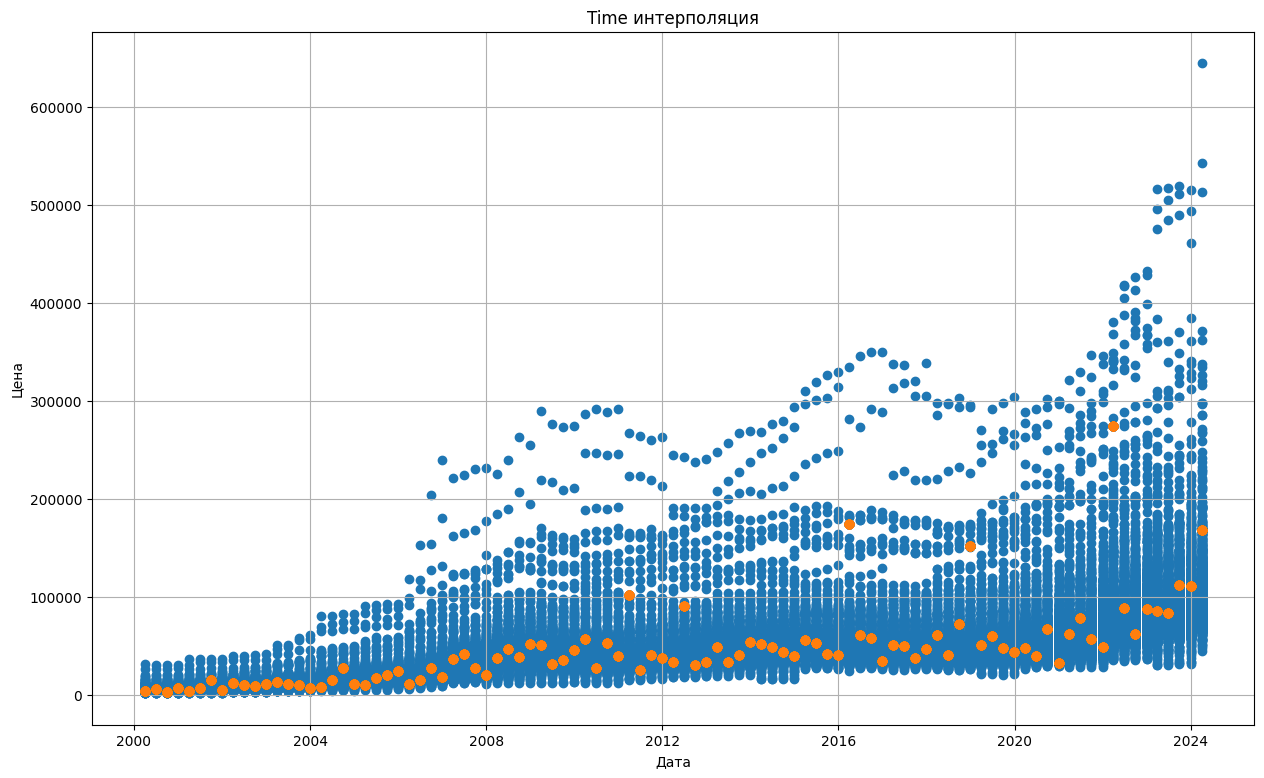

In [ ]:
plt.figure(figsize=(15, 9))
plt.scatter(df_melted.index, df_melted['Цена'])
plt.scatter(df_melted.index[df_melted_nan], df_melted['Цена'][df_melted_nan], label='Замененные значения', zorder=5)

plt.title('Time интерполяция')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

Дальше, либо генерим новые признаки, или сами добываем, например можно добавить курс доллара, или лаги, какие нибудь временные метки

Добавляем курс доллара

In [ ]:
dollar = pd.read_excel('/content/sample_data/Курс доллара с 01.01.2000 по 31.01.2024.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
dollar

,nominal,data,curs,cdx
0,1,2024-01-31,89.2887,Доллар США
1,1,2024-01-30,89.6090,Доллар США
2,1,2024-01-27,89.5159,Доллар США
3,1,2024-01-26,88.6562,Доллар США
4,1,2024-01-25,88.2829,Доллар США
...,...,...,...,...
5965,1,2000-01-12,28.4400,Доллар США
5966,1,2000-01-11,27.7300,Доллар США
5967,1,2000-01-07,27.2300,Доллар США
5968,1,2000-01-06,26.9000,Доллар США


In [ ]:
per = pd.DatetimeIndex(dollar.data)
dollar.index = per

In [ ]:
dollar = dollar.drop(['data', 'nominal', 'cdx'], axis=1)

In [ ]:
df_quarterly = dollar['curs'].resample('Q').mean()

<ipython-input-341-2cf0adbb8995>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = dollar['curs'].resample('Q').mean()


In [ ]:
df_quarterly

,curs
data,
2000-03-31,28.489180
2000-06-30,28.383279
2000-09-30,27.792424
2000-12-31,27.885556
2001-03-31,28.553607
...,...
2023-03-31,72.971143
2023-06-30,81.240192
2023-09-30,94.200117


In [ ]:
df_melted = df_melted.join(df_quarterly)

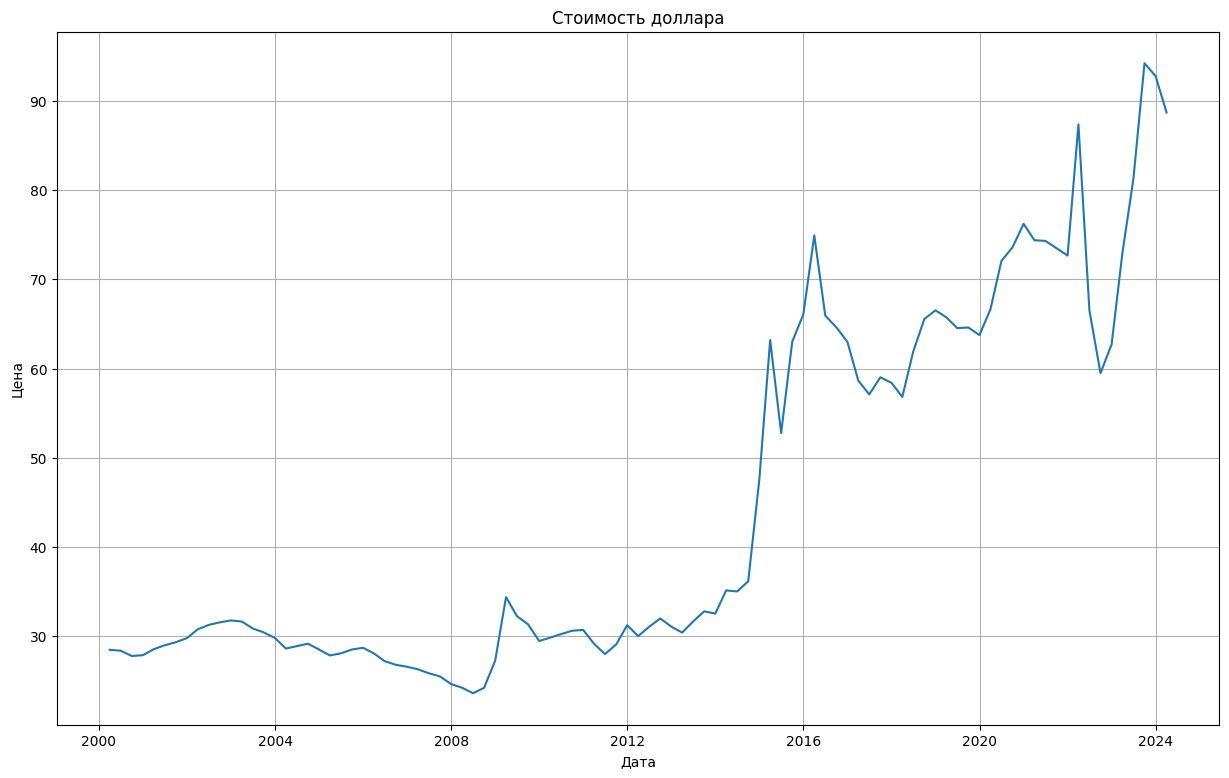

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(df_melted.index, df_melted['curs'])

plt.title('Стоимость доллара')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)

plt.show()

In [ ]:
df_melted

,Цена,Вторичный рынок жилья,Первичный рынок жилья,Алтайский край,Амурская область,Архангельская область,Архангельская область (кроме Ненецкого автономного округа),Астраханская область,Белгородская область,Брянская область,...,Чукотский автономный округ,Южный федеральный округ,Ямало-Ненецкий автономный округ (Тюменская область),Ярославская область,Все типы квартир,Квартиры среднего качества (типовые),Низкого качества,Улучшенного качества,Элитные квартиры,curs
2000-03-31,5910.45,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,28.489180
2000-03-31,3775.70,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,28.489180
2000-03-31,3775.70,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,28.489180
2000-03-31,3775.70,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,28.489180
2000-03-31,5208.58,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,28.489180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,168352.16,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,88.680288
2024-03-31,123120.66,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,88.680288
2024-03-31,100788.93,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,88.680288
2024-03-31,92723.64,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,88.680288


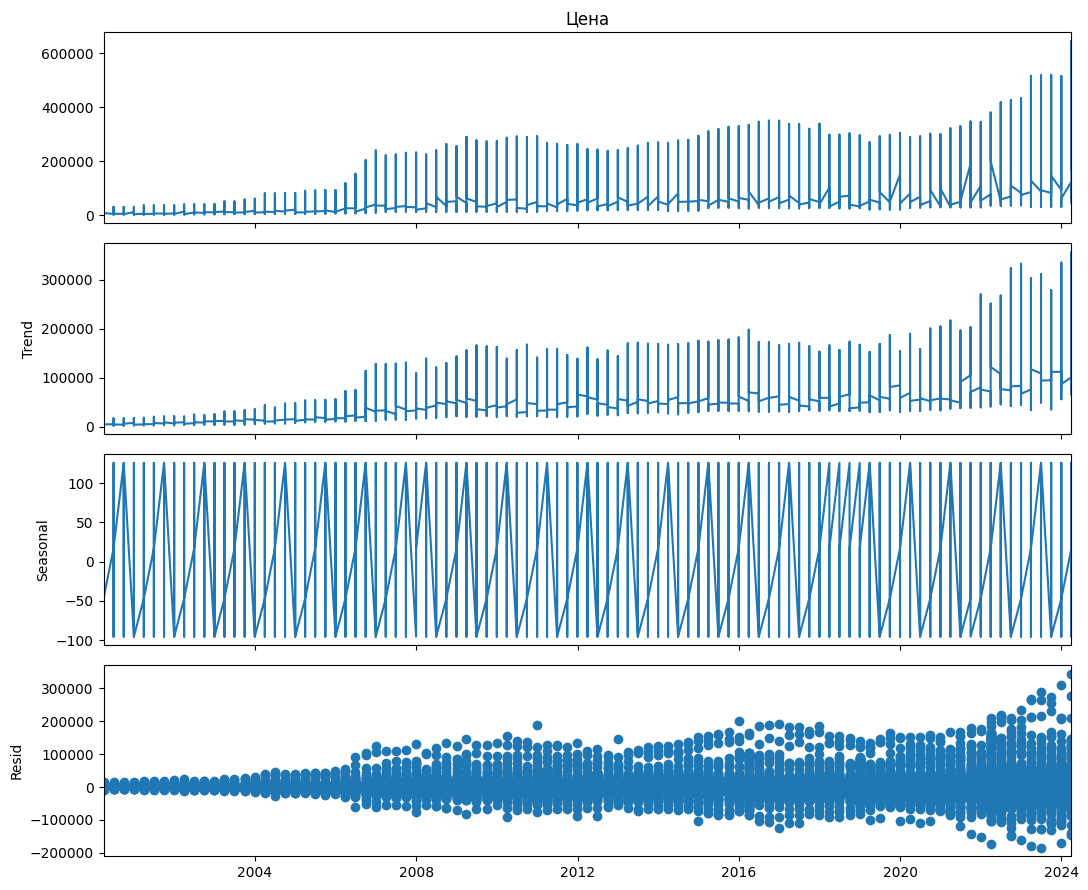

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

df_melted = df_melted.sort_index()
decompose = seasonal_decompose(df_melted['Цена'], period=4)
decompose.plot()
plt.show()

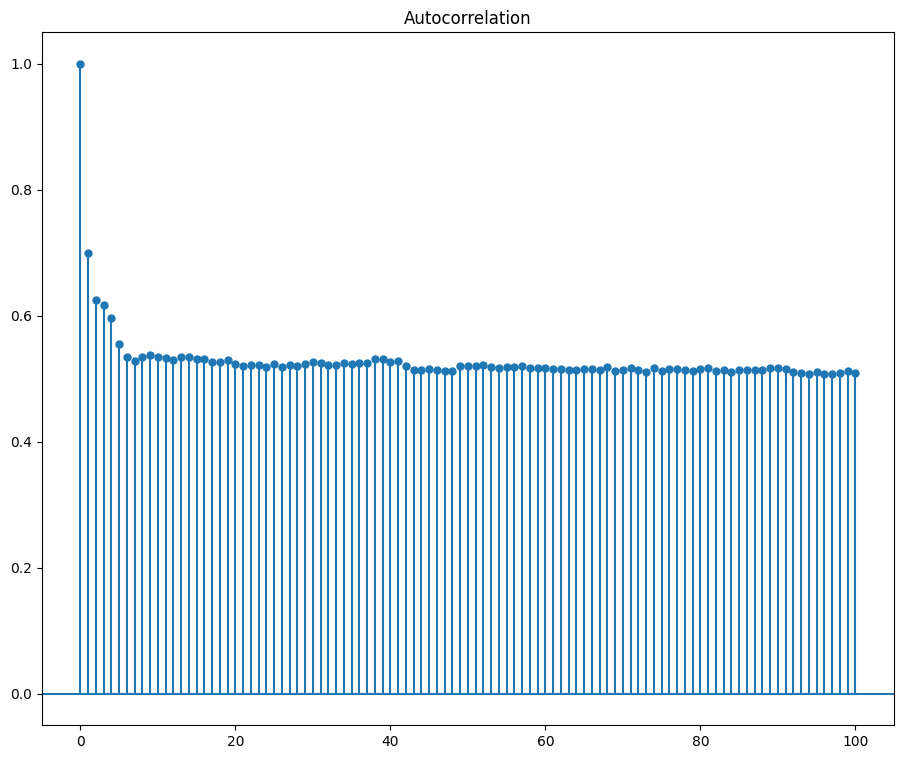

In [ ]:
acf = plot_acf(df_melted['Цена'], lags = 100, alpha=None)
plt.axis('tight')
plt.show()

Добавим экспоненциальное сглаживание


In [ ]:
alpha = 0.2
exp_smoothing = [df_melted['Цена'].iloc[0]]

for i in range(1, len(df_melted['Цена'])):
  exp_smoothing.append(alpha * df_melted['Цена'].iloc[i] + (1-alpha) * exp_smoothing[i-1])

In [ ]:
df_melted['exp_smoothing'] = exp_smoothing
df_melted.tail()

,Цена,Вторичный рынок жилья,Первичный рынок жилья,Алтайский край,Амурская область,Архангельская область,Архангельская область (кроме Ненецкого автономного округа),Астраханская область,Белгородская область,Брянская область,...,Южный федеральный округ,Ямало-Ненецкий автономный округ (Тюменская область),Ярославская область,Все типы квартир,Квартиры среднего качества (типовые),Низкого качества,Улучшенного качества,Элитные квартиры,curs,exp_smoothing
2024-03-31,168352.16,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,88.680288,122151.873087
2024-03-31,123120.66,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,88.680288,122345.630469
2024-03-31,100788.93,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,88.680288,118034.290376
2024-03-31,92723.64,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,88.680288,112972.160300
2024-03-31,168352.16,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,88.680288,124048.160240


Проверим правильность рассчета